In [1]:
import sys 
sys.path.append('r/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm')
from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import jax
from jax import vmap, jit
from flax import linen as nn
import matplotlib.pyplot as plt # creating visualizations
from functools import partial

### Generate Data

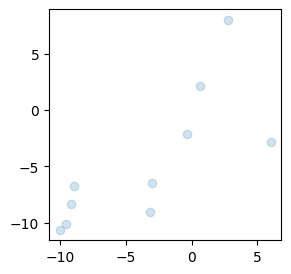

In [2]:
def generate_data_curved(key, n_samples):
  keys = jr.split(key, 2)
  epsilon = jr.normal(keys[0], shape=(n_samples, ))
  x_data = jr.uniform(keys[1], (n_samples, ), minval=-10.5, maxval=10.5)
  y_data = 7*jnp.sin(0.75*x_data) + 0.5*x_data + epsilon
  return jnp.array([x_data, y_data])

def generate_data_nl_gaussian(key, n_samples):
  keys = jr.split(key, 2)
  u  = jr.normal(keys[0], shape=(n_samples, 2))
  x = 2 * u[:, 0]
  y = x ** 2 / 4 + u[:, 1]
  return jnp.array([y, x])
  
n_samples = batch_size = 10 # just use train everything in a batch
data = generate_data_curved(jr.PRNGKey(0), n_samples).T
# x_data = jnp.array(x_data.reshape(batch_size, 1))
# y_data = jnp.array(y_data.reshape(batch_size, 1))

# plot the original data and the test data
plt.figure(figsize=(3, 3))
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.show()

### MADE dev (introduce order-agnostic training)

In [3]:
@partial(jit, static_argnums=(1,2,3))
def create_degrees(key, din, dhidden, nhidden):
    """
    Generates a degree for each hidden and input unit. A unit with degree d can only receive input from units with
    degree less than d.
    :param n_inputs: the number of inputs
    :param n_hiddens: a list with the number of hidden units
    :param input_order: the order of the inputs; can be 'random', 'sequential', or an array of an explicit order
    :param mode: the strategy for assigning degrees to hidden nodes: can be 'random' or 'sequential'
    :return: list of degrees
    """

    degrees = []
    keys = jr.split(key, nhidden + 1)

    degrees_0 = jnp.arange(1, din + 1)
    # degrees_0 = jr.permutation(keys[0], degrees_0, independent=True)
    degrees.append(degrees_0)

    for n in range(nhidden):
        min_prev_degree = jnp.min(jnp.array([jnp.min(degrees[-1]), din - 1]))
        degrees_l = jr.randint(keys[n+1], (dhidden, ), min_prev_degree, din)
        degrees.append(degrees_l)

    return degrees

@jit
def create_masks(degrees):
    """
    Creates the binary masks that make the connectivity autoregressive.
    :param degrees: a list of degrees for every layer
    :return: list of all masks, as theano shared variables
    """

    Ms = []

    for _, (d0, d1) in enumerate(zip(degrees[:-1], degrees[1:])):
        M = d0[:, jnp.newaxis] <= d1
        Ms.append(M.astype(int))

    Mmp = degrees[-1][:, jnp.newaxis] < degrees[0]

    return Ms, Mmp.astype(int)

In [4]:
from inference import Linear
from jax import debug

class OAMADE_Params(nnx.Module):
    def __init__(self, din: int, dhidden: int, nhidden: int, *, rngs: nnx.Rngs):
        dout = din
        self.din, self.dhidden, self.nhidden = din, dhidden, nhidden
        degrees = create_degrees(rngs.split(), din, dhidden, nhidden)
        masks = create_masks(degrees)
        in_mask = masks[0][0]
        mid_masks = masks[0][1:]
        out_mask = masks[1]
        self.input_order = degrees[0]
        self.mu1 = 0.0
        self.sigma1 = 1.0
        for i in range(nhidden):
            if i == 0:
                setattr(self, f'linear{i+1}', Linear(in_mask, din, dhidden, rngs=rngs))  
                setattr(self, f'dropout{i+1}', nnx.Dropout(rate=0.1, rngs=rngs))  
                setattr(self, f'bn{i+1}', nnx.BatchNorm(dhidden, rngs=rngs))
            else:
                setattr(self, f'linear{i+1}', Linear(mid_masks[i-1], dhidden, dhidden, rngs=rngs))
                setattr(self, f'dropout{i+1}', nnx.Dropout(rate=0.1, rngs=rngs))
                setattr(self, f'bn{i+1}', nnx.BatchNorm(dhidden, rngs=rngs))
            self.linear_mu = Linear(out_mask, dhidden, dout, rngs=rngs)
            self.linear_alpha = Linear(out_mask, dhidden, dout, rngs=rngs)

    def __call__(self, x: jax.Array):
        for i in range(self.nhidden):
            linear = getattr(self, f'linear{i+1}')
            dropout = getattr(self, f'dropout{i+1}')
            bn = getattr(self, f'bn{i+1}')
            x = linear(x)
            x = bn(x)
            x = dropout(x)
            x = nnx.relu(x)
        return jnp.stack([self.linear_mu(x), self.linear_alpha(x)], axis=1)
  
class OAMADE(nnx.Module):
    def __init__(self, din: int, dhidden: int, nhidden: int, *, rngs: nnx.Rngs):
        self.made_params = OAMADE_Params(din, dhidden, nhidden, rngs=rngs)
        self.din = din
        self.input_order = self.made_params.input_order

    def __call__(self, x: jax.Array):
        """
        Implements the inverse MADE transformation x -> u
        A note on the order of the inputs: the made_params call function computes the parameters mu and alpha for the 
        ordering given by the 
        """
        num_samples = x.shape[0]
        params = self.made_params(x)

        mus = params[:, 0]
        mus = mus[:, jnp.argsort(self.input_order)]
        mus = jnp.stack([jnp.tile(self.mu1, (num_samples, 1)), mus[:, 1:]], axis=1).squeeze()

        alphas = params[:, 1]
        alphas = alphas[:, jnp.argsort(self.input_order)]
        alphas = jnp.stack([jnp.tile(jnp.log(self.sigma1), (num_samples, 1)), alphas[:, 1:]], axis=1).squeeze()
        
        us = jnp.exp(-alphas) * (x[:, jnp.argsort(self.input_order)] - mus)
        return us, jnp.sum(alphas)

    def generate(self, u):
        assert len(u.shape) == 2
        x = jnp.zeros(jnp.shape(u))
        x1 = self.mu1 + self.sigma1 * u[:, 0]
        idx = jnp.argwhere(self.input_order == 1)[0, 0]
        x = x.at[:, idx].set(x1)
        for i in range(2, self.din+1):
            idx = jnp.argwhere(self.input_order == i)[0, 0]
            params = self.made_params(x)    
            mus = params[:, 0]
            alphas = params[:, 1]
            new_x = mus[:, idx] + jnp.exp(alphas[:, idx]) * u[:, i-1]
            x = x.at[:, idx].set(new_x)
        return x
  
    def sample(self, key, num_samples):
        u = jr.normal(key, (num_samples, self.din))
        return self.generate(u)
    
    def train_init(self, x):
        idx = jnp.argwhere(self.input_order == 1)[0, 0]
        mu1 = jnp.mean(x[:, idx])
        sigma1 = jnp.std(x[:, idx])
        self.mu1 = mu1
        self.sigma1 = sigma1
  
    def loss_fn(self, x):
        self.train()
        us, sum_alphas = self(x)
        return jnp.sum(us ** 2)/2 + sum_alphas

### Training

In [5]:
import optax
from jax import debug

# from inference import MADE, MADE2

# MLP contains 2 Linear layers, 1 Dropout layer, 1 BatchNorm layer
key1, key2 = jr.split(jr.PRNGKey(0))
model2 = MADE2(2, 16, 5, rngs=nnx.Rngs(0))
learning_rate = 0.01
momentum = 0.9
optimizer = nnx.Optimizer(model2, optax.adamw(learning_rate, momentum))

@nnx.jit  # automatic state management
def train_step(model2, optimizer, data):
  loss_fn = lambda model: model.loss_fn(data)
  loss, grads = nnx.value_and_grad(loss_fn)(model2)
  optimizer.update(grads)  # inplace updates
  return loss

losses = []
num_epochs = 5
minibatch_size = 100
model2.train_init(data)
print('Init values:', model2.mu1, model2.sigma1)
for i in range(num_epochs):
  loss = train_step(model2, optimizer, data)
# keys = jr.split(key1, num_epochs)
# for i in range(num_epochs):
#   mini_batch = data[jax.random.randint(keys[i], (minibatch_size,), 0, data.shape[0])]
#   loss = train_step(model2, optimizer, mini_batch)
  losses.append(loss)
  if i % 100 == 0:
    print(f'Iteration {i}, Loss {loss}')

Init values: -3.4925148 5.467104
[[-3.4925148 -1.2518709]
 [-3.4925148 -1.1083486]
 [-3.4925148 -1.3351723]
 [-3.4925148 -1.2650026]
 [-3.4925148  3.664221 ]
 [-3.4925148 26.06313  ]
 [-3.4925148 -1.350268 ]
 [-3.4925148 -1.2695037]
 [-3.4925148 -1.3823835]
 [-3.4925148 -1.3060871]]
Iteration 0, Loss 2151.442138671875
[[-3.4925148 -1.1517518]
 [-3.4925148 -1.3677648]
 [-3.4925148 -1.1972315]
 [-3.4925148 -1.1295445]
 [-3.4925148  2.8526418]
 [-3.4925148 24.450838 ]
 [-3.4925148 -1.265206 ]
 [-3.4925148 -1.239993 ]
 [-3.4925148 -1.3981795]
 [-3.4925148 -1.3778954]]
[[-3.4925148 -1.2791952]
 [-3.4925148 -1.263536 ]
 [-3.4925148 -1.3125122]
 [-3.4925148 -1.0263891]
 [-3.4925148  0.5763257]
 [-3.4925148 23.319641 ]
 [-3.4925148 -1.1812469]
 [-3.4925148 -1.377719 ]
 [-3.4925148 -1.3461052]
 [-3.4925148 -1.1608118]]
[[-3.4925148 -1.3499041]
 [-3.4925148 -1.2001656]
 [-3.4925148 -1.3103144]
 [-3.4925148 -1.1020927]
 [-3.4925148  2.1772335]
 [-3.4925148 25.123056 ]
 [-3.4925148 -1.4086376]
 [-

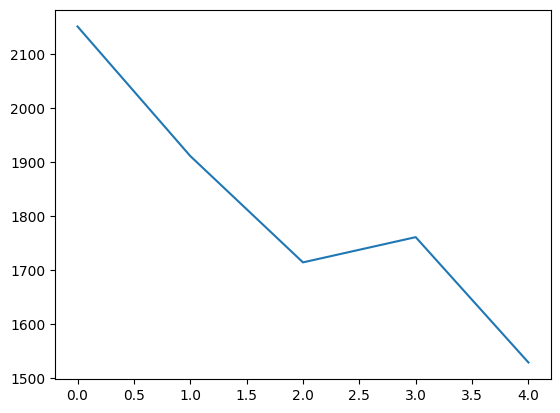

In [6]:
plt.plot(losses)
plt.show()

### Evaluation

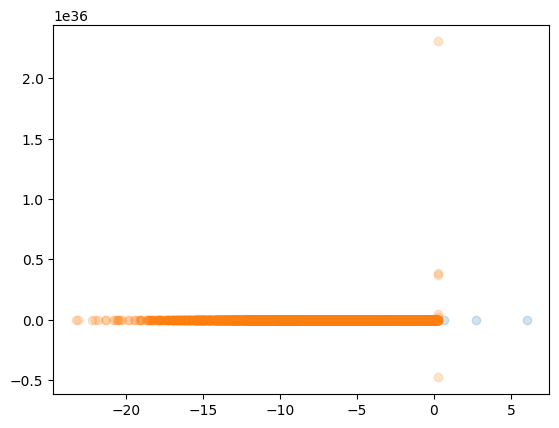

In [7]:
model2.eval()
num_samples = 10000
samples = model2.sample(jr.PRNGKey(0), num_samples)
idx0 = jnp.argwhere(model2.input_order == 1)[0, 0]
idx1 = jnp.argwhere(model2.input_order == 2)[0, 0]
samples = samples[:, [idx0, idx1]]
# samples = samples[samples[:, 1]<10]
# samples = samples[samples[:, 1]>-10]
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.scatter(samples[:, 0], samples[:,1], alpha=0.2)
plt.show()
# plt.hist(samples[:,0], bins=100, alpha=0.5)
# plt.hist(data[:,0], bins=100, alpha=0.5)
# plt.show()

[[-3.4925148e+00 -1.7531509e+00]
 [-3.4925148e+00 -1.7524915e+00]
 [-3.4925148e+00 -1.7537186e+00]
 [-3.4925148e+00  6.0263763e+02]
 [-3.4925148e+00  4.4743965e+03]
 [-3.4925148e+00  1.0720398e+04]
 [-3.4925148e+00 -1.7535167e+00]
 [-3.4925148e+00 -1.7536613e+00]
 [-3.4925148e+00 -1.7531745e+00]
 [-3.4925148e+00 -1.7535881e+00]]


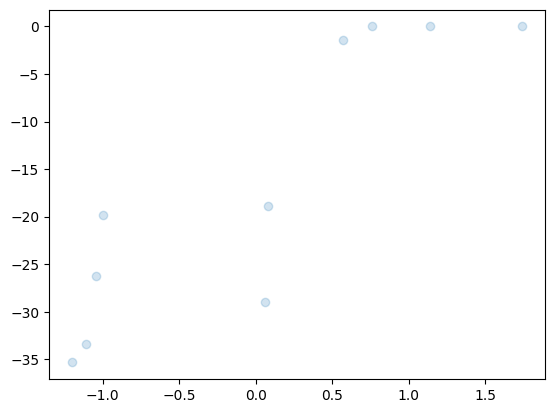

In [8]:
us, alphas = model2(data)
plt.scatter(us[:,0], us[:,1], alpha=0.2)
plt.show()

### Debugging

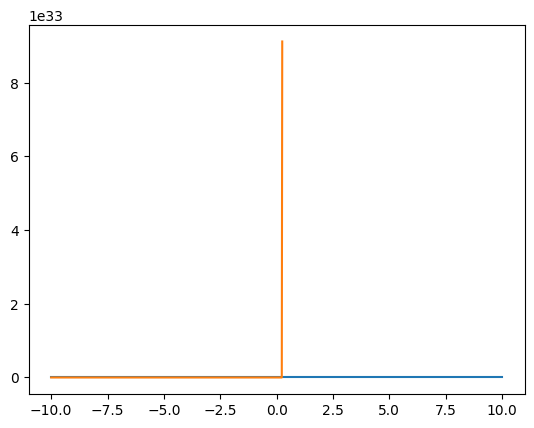

In [9]:
made_params = model2.made_params
line = jnp.linspace(-10, 10, 1000)
input_order = model2.input_order
ids = jnp.argsort(input_order)
in_data = jnp.stack([line, jnp.ones(1000)], axis=1)
in_data = in_data[:, ids]
mus = made_params(in_data)[:, 0]
alphas = made_params(in_data)[:, 1]
id = jnp.argwhere(input_order == 2)[0, 0]
plt.plot(line, mus[:, id])
plt.plot(line, jnp.exp(alphas[:, id]))
plt.show()

In [10]:
# import optax
# from inference import MADE

# # MLP contains 2 Linear layers, 1 Dropout layer, 1 BatchNorm layer
# key1, key2 = jr.split(jr.PRNGKey(0))
# model1 = MADE(2, 16, 5, rngs=nnx.Rngs(0))
# learning_rate = 0.01
# momentum = 0.9
# optimizer = nnx.Optimizer(model1, optax.adamw(learning_rate, momentum))

# @nnx.jit  # automatic state management
# def train_step(model1, optimizer, data):
#   loss_fn = lambda model: model.loss_fn(data)
#   loss, grads = nnx.value_and_grad(loss_fn)(model1)
#   optimizer.update(grads)  # inplace updates
#   return loss

# losses = []
# num_epochs = 3000
# minibatch_size = 100
# data = data[:, [1, 0]]
# model1.train_init(data)
# for i in range(num_epochs):
#   loss = train_step(model1, optimizer, data)
#   losses.append(loss)
#   if i % 100 == 0:
#     print(f'Iteration {i}, Loss {loss}')

In [11]:
# model1.eval()
# num_samples = 10000
# samples = model1.sample(jr.PRNGKey(0), num_samples)
# idx0 = 0
# idx1 = 1
# samples = samples[:, [idx0, idx1]]
# plt.scatter(data[:,0], data[:,1], alpha=0.2)
# plt.scatter(samples[:, 0], samples[:,1], alpha=0.2)
# plt.show()


In [12]:
# made_params1 = model1.made_params
# line = jnp.linspace(-10, 10, 1000)
# in_data = jnp.stack([line, jnp.ones(1000)], axis=1)
# mus = made_params1(in_data)[:, 0]
# alphas = made_params1(in_data)[:, 1]
# # plt.scatter(data[:,1], data[:,0], alpha=0.2)
# plt.plot(line, mus[:, 1])
# plt.plot(line, jnp.exp(alphas[:, 1]))
# plt.show()